![Py4Eng](img/logo.png)

# Linear Model
## Yoav Ram

In this session we will understand:
- how linear models can be used to predict or interpolate data
- how to fit linear models to data using maximum likelihood and gradient descent
- how to visualize scatterplots, linear models, and histograms
- the basics of pandas, matplotlib, and seaborn
- how to download and open zip files

In [1]:
import urllib.request
import os
import zipfile

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import scipy.optimize
import seaborn as sns

import warnings
warnings.simplefilter('ignore', FutureWarning)

# Get the data

We will use some tennis data so that we can talk about *linear regression*.

We start by openning the zip file and print its contents.

Note 1: [`zipfile`](https://docs.python.org/3/library/zipfile.html) is part of Python standard library, which also includes modules for [`gzip`](https://docs.python.org/3/library/gzip.html), [`bz2`](https://docs.python.org/3/library/bz2.html) and other compression formats.
Note 2: Data from the [IPython Cookbook: example data](https://github.com/ipython-books/cookbook-data) repo.

In [2]:
filename = '../data/tennis.zip'
tennis_zip = zipfile.ZipFile(filename)
for f in tennis_zip.filelist: 
    print(f.filename)

data/Andy-Murray.csv
data/Novak-Djokovic.csv
data/Rafael-Nadal.csv
data/Roger-Federer.csv


So we have CSV files for Tennis' [Big Four](https://en.wikipedia.org/wiki/Big_Four_%28tennis%29).

We can open CSV files with the standard library's [`csv`](https://docs.python.org/3/library/csv.html) module, but it is much more convinient to use Pandas.

In [3]:
player = 'Novak Djokovic'
path = 'data/{}.csv'
path = path.format(player.replace(' ', '-'))
with tennis_zip.open(path) as f:
    df = pd.read_csv(f)
df.head()

,year,tournament,start date,type,surface,draw,atp points,atp ranking,tournament prize money,round,...,player2 2nd serve return points total,player2 break points converted won,player2 break points converted total,player2 return games played,player2 total service points won,player2 total service points total,player2 total return points won,player2 total return points total,player2 total points won,player2 total points total
0,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,R16,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,Q,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2003,"Serbia F6, Beograd",28.07.2003,FU,Outdoor: Clay,Draw: 32,4,709.0,$480,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2003,"Serbia F5, Beograd",21.07.2003,FU,Outdoor: Clay,Draw: 32,NaN,774.0,$118,R32,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Exercise: plotting

Plotting is done by calling functions from the `plot` attribute of the dataframe, but the underlying mechanism is at work is *matplotlib*, the fundamental Python plotting library.

Now let's plot the points won vs points aced to try and see if one can explain the other.

Bonus points: `marker` and `alpha` keyword arguments control the marker shape and the transparency, use these arguments to plot with `.` instead of the default `o` and with tranparancy of 3/4.

**Reminder**
- Edit cell by double clicking
- Run cell by pressing _Shift+Enter_
- Get autocompletion by pressing _Tab_
- Get documentation by pressing _Shift+Tab_

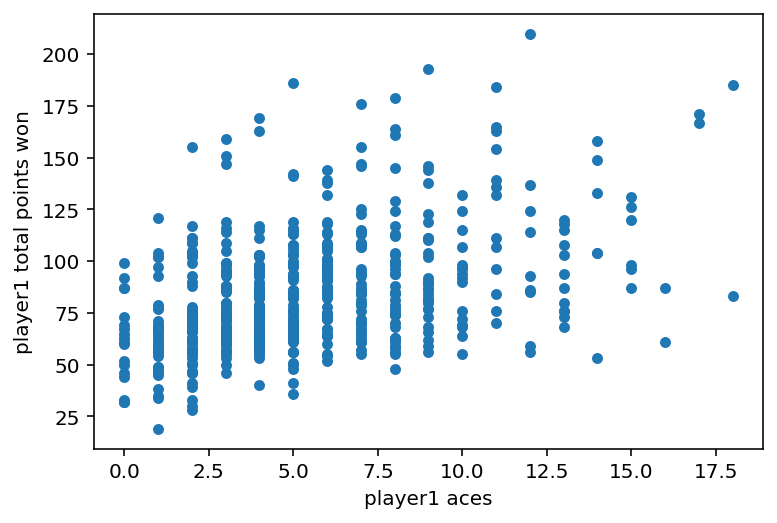

# Linear model

Can the number of aces by Novak provide a good predictor of the number of points he won?

The simplest model for such predictions is the linear model
$$
\widehat{y} = ax + b
$$
where here $x$ is the aces and $y$ is the points won.
The model parameters can be interpreted as follows:
- the intercept $b$ is the estimate for points won if 0 points were aced, $b = \widehat{y}(x=0)$, and
- the slope $a$ is the estimate for the linear increase in points won for every additional ace, $a = \widehat{y}(x+1)-\widehat{y}(x)$.

How do we find suitable $a$ and $b$?
For a given $a$ and $b$, we mark the real points won as $y$ and calculate the distance between the predictions and the observed values.
We plot a histogram of these differences, called [residuals](https://en.wikipedia.org/wiki/Errors_and_residuals).
Here, `bins` controls the number (if `int`) or locations (if `list`) of the histogram bins.

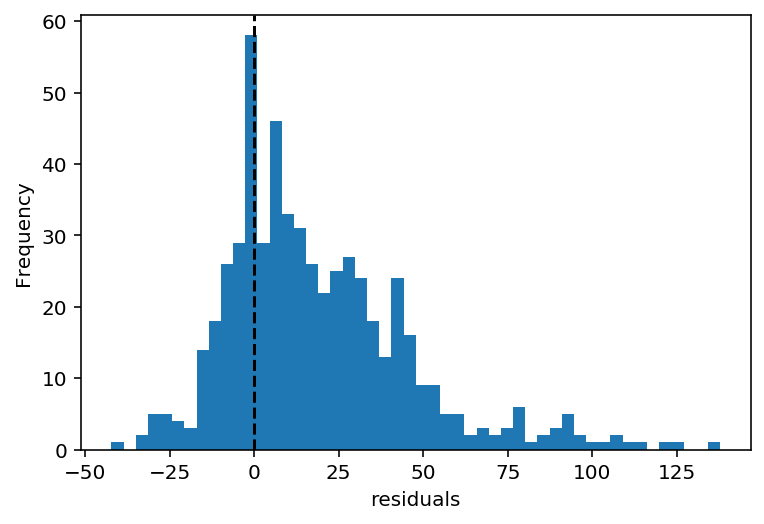

In [7]:
X = df['player1 aces']
Y = df['player1 total points won']

a = 1
b = np.mean(Y[X==0])

Yhat = a * X + b
residuals = Y - Yhat

residuals.plot.hist(bins=50)
plt.axvline(x=0, color='k', ls='--')
plt.xlabel('residuals');

We can see that the distribution is not really gaussian/normal, we'll get back to that later.

# Maximum likelihood & least squares

In the simplest form of linear modeling, we assume that the residuals (the distance between our prediction and the observed values) has a [normal (or Gaussian) distribution](https://en.wikipedia.org/wiki/Normal_distribution). 
However, this assumption is not a must, and the framework of [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model) allow us to replace the normal distribution with other distributions such as the binomial distribution (which might be more suitable in this case, in which y values are integers).
We'll talk about it again later.

Usually, when we speak about probabilities, we ask *"what is the probability to see this data given this model"* - when I say "model" I mean something like $y=ax+b$ with given values for $a$ and $b$, such as $a=1$ and $b=0$, and a normal distribution of errors, that is, that observed values should be normally distributed around the expected value:
$$
y \sim Normal\big(\widehat{y}, \sigma^2\big)
$$
where $\sigma^2$ is the variance of the distribution.

That is, we want to say something about expected data given a model.

For example, given this model ($y=x$), if $x=5$ then the probability for $y=2$ is:
$$
P(y=2) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(2-5a-b)^2}{2\sigma^2}\bigg),
$$
and in general, the probability for an observation $y$ is
$$
P(y) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\bigg(-\frac{(y - \widehat{y})^2}{2\sigma^2}\bigg).
$$

But in cases where we have data and we try to say something about the expected model given observed data.
This is where *likelihood* comes into place, and its definition is straight-forward:
The **likelihood of the model** $y \sim Normal(ax+b, \sigma^2)$ given observed data $(x, y)$ is the probability of seeing data $(x,y)$ given the model $y \sim Normal(ax+b, \sigma^2)$.

If we have mutliple data points (we do!) we just multiply all of them under the assumption that each data point (here, game point, so.. confusing) is *independent* (in the probability sense of independence, that is, knowing what happened in one of them doesn't change the probability of the other one occuring).

So the likelihood of the model $y \sim Normal(ax+b, \sigma^2)$ given data points $(x_i, y_i)$, where $i$ indexes the point, is
$$
\mathbf{L}(a,b | x_i, y_i) = (2 \pi \sigma^2)^{-n/2} \prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i - ax_i -b)^2}{2\sigma^2}\bigg)}
$$

After establishing what likelihood is, we can ask _what are the parameters $a$ and $b$ that maximize the model likelihood?_. 

This is akin to asking what are $a$ and $b$ for which the probability of seeing the data we saw is maximized.
This approach is called **maximum likelihood**.

Now, our likelihood $\mathbf{L}$ is a product of exponents, so we can take the log-likelihood (literally the log of the likelihood) to get a simpler expression
$$
\log\mathbf{L} = \\
\log (2 \pi \sigma^2)^{-n/2} + \log{\prod_{i=1}^{n}{ exp\bigg(-\frac{(y_i - ax_i -b)^2}{2\sigma^2}\bigg)}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} + \sum_{i=1}^{n}{-\frac{(y_i-ax_i-b)^2}{2\sigma^2}} = \\
-\frac{n}{2}\log{(2 \pi \sigma^2)} - \frac{1}{2\sigma^2} \sum_{i=1}^{n}{(y_i-ax_i-b)^2}
$$

Note that 
- $\log{\mathbf{L}}$ is an increasing function of $\mathbf{L}$ so maximizing the log-likelihood is equivalent to maximizing the likelihood
- $a$ and $b$ only appear in the sum-of-squares, which is prepended by a negative sign, so minimizing the sum-of-squares is equivalent to maximizing the log-likelihood
- if we only care about the best estimate of $a$ and $b$ then we don't really care about the variance $\sigma^2$ (we would care if we wanted to have some statistical measure of precision or confidence)

This is where the **least squares** approach comes from: when assuming a model with normal distribution of residuals, maximizing the likelihood is equivalent to minimizing the sum-of-squares of the residials, or the deviances between the model prediction $\widehat{y}$ and the observed value $y$.

Note that this works with non-linear models just the same, as long as the residuals are normally and independently distributed.

In ths case of a linear model there is a formula to find $a$ and $\sigma^2$ when $b=0$, but since we will later deal with cases in which there is no formula, let's continue as if there is no formula.

Let's calculate the sum-of-squares. 
Note that Pandas aggregation methods (such as `sum` or `mean`) ignore NaN values, but this is not always the case in other numerical packages.

In [8]:
(residuals**2).sum()

620817.462603878

## Exercise: sumsquares

Write a function that calculates the sum-of-squares for some $a$ and $b$ values and the data $x,y$:

In [9]:
def sumsquares(a, b, X, Y):
    # your code here

In [10]:
sumsquares(a, b, X, Y)

620817.462603878

Now we would like to find $a$ and $b$ that minimize the function `sumsquares`.

# Gradient descent

One way to do this is with *gradient descent*.
This is an iterative algorithm.
In each step, we calculate that gradient of the function (sum-squares) with respect to model parameters $a$ and $b$ (the gradient is just the vector of derivatives):
$$
RSS \big(a, b, x, y\big) = \sum_{i=1}^{n}{(y_i-ax_i-b)^2} \\
\frac{\partial RSS}{\partial a} = \sum_{i=1}^{n}{2ax^2 +2bx -2xy} \\
\frac{\partial RSS}{\partial b} = \sum_{i=1}^{n}{2ax +2b -2y}
$$
and "descend" (minimize) the function just a tiny bit by updating $a$ and $b$ in the oppositve direction of the gradient:
$$
a_t = a_{t-1} - \eta \frac{\partial RSS}{\partial a} \\ 
b_t = b_{t-1} - \eta \frac{\partial RSS}{\partial b}
$$
where $\eta$ is the size of the step we take (the "tiny bit"), also sometimes called the *learning rate*. We'll talk later about methods in which this rate can be learned or adjusted over time.

Let's try it!


In [13]:
def gradient_descent(a, b, X, Y, η):
    dRSSda = (2*a*X*X + 2*b*X -2*X*Y).sum()
    dRSSdb = (2*a*X + 2*b - 2*Y).sum()
    return a - η * dRSSda, b - η * dRSSdb

The last technical details is the stopping condition.
We'll set the gradient descent to stop after 5000 iterations (we can run more afterwards if we want by setting `a` and `b` to start where we left off).

In [16]:
def linear_model(X, Y, a=0, b=0, η=0.00001, iters=5000):    
    for t in range(iters+1):
        a, b = gradient_descent(a, b, X, Y, η)
        if t % 500 == 0:            
            print("{}: RSS={:.4f}, a={:.4f}, b={:.4f}".format(t, sumsquares(a, b, X, Y), a, b))
    return a, b

In [17]:
a, b = linear_model(X, Y)

0: RSS=1979612.1580, a=5.6627, b=0.9533
500: RSS=406387.2995, a=5.0880, b=53.1186
1000: RSS=381693.1769, a=3.7785, b=63.1285
1500: RSS=380755.2315, a=3.5233, b=65.0793
2000: RSS=380719.6059, a=3.4736, b=65.4595
2500: RSS=380718.2528, a=3.4639, b=65.5336
3000: RSS=380718.2014, a=3.4620, b=65.5481
3500: RSS=380718.1994, a=3.4616, b=65.5509
4000: RSS=380718.1993, a=3.4615, b=65.5514
4500: RSS=380718.1993, a=3.4615, b=65.5516
5000: RSS=380718.1993, a=3.4615, b=65.5516


# Plot and interpret a linear model

Let's plot the results.
We now load the [matplotlib](http://matplotlib.org) library to use it to plot a straight line over the scatterplot. Note that we sort the x values first otherwise the straight line will zigzag over the plot.

a=3.4615302824464615, b=65.55157465351931


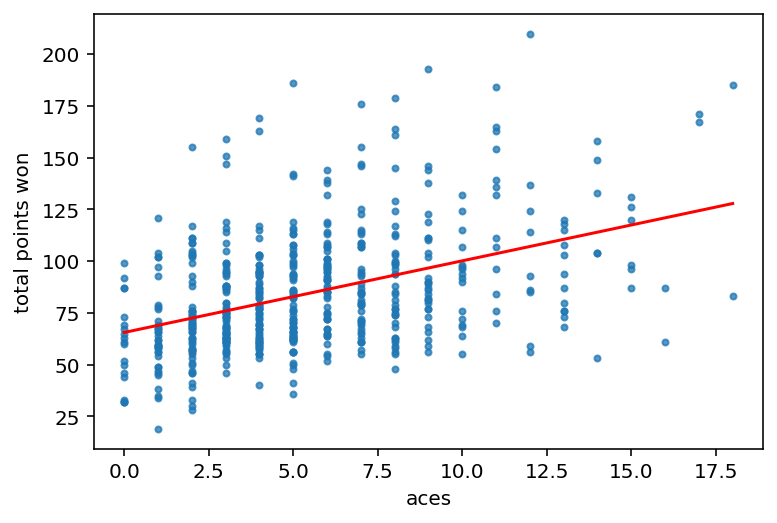

In [18]:
def plot_linear_model(a, b, X, Y, **plot_kws):
    plt.scatter(X, Y, marker='.', alpha=0.75)
    X_ = X.sort_values()
    plt.plot(X_, a * X_ + b, '-r', **plot_kws)
    plt.xlabel('aces')
    plt.ylabel('total points won')
    print("a={}, b={}".format(a, b))
    
plot_linear_model(a, b, X, Y);

The results can be interpreted as follows
- without any aces, Novak wins ~65 points. 
- for any additional ace, he wins an additional ~3.5 point (more than the one point given by the ace)

This model will probably do a good job at *interpolation*, that is estimating $\widehat{y}$ for $x$ values that are within the original $x$ values, but not at *extrapolation*.
For example, if Novak aces all the points in a game, he can't wint 3.5 times the points he aced!

# Off-the-shelf solutions

Let's see how we could have done this with Python's packages instead of reinventing the wheel.

We'll work with NumPy and SciPy, the numerical and scientific backbone of scientific Python.

NumPy and SciPy don't like NaNs, which we have a lot. We can fliter them with `np.isfinite` or just by taking only the non-negative values (NaN are not negative but are also not non-negative).

In [19]:
Y = Y[np.isfinite(X)]
X = X[np.isfinite(X)]

## NumPy

First method is NumPy's `polyfit` which fits a polynomial of specified degree to the data; in this case we want degree one. It returns the coefficients of the polynomial, which we could feed to `np.poly1d` to create a callable polynomial object.

In [20]:
a_np, b_np = np.polyfit(X, Y, 1)
print(a_np, b_np)

3.461529622720437 65.55157969668237


Note how much faster NumPy does it.
This is because under-the-hood NumPy calls native code (C/Fortran).
The main drain of calculation time is probably the `while` loop in `linear_model` as each iteration performs redundent type check etc.

In [23]:
%timeit -n 1 -r 1 linear_model(X, Y)
%timeit np.polyfit(X, Y, 1)

1.35 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
162 µs ± 8.99 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


## SciPy
Next is SciPy's statistics package with its linear regression method, which basically uses the same method `polyfit` does (i.e. exact same result) but then also calculates some statistics.

In [21]:
res = scipy.stats.linregress(X, Y)
print(res.slope, res.intercept)

3.4615296227204424 65.55157969668234


The P-value gives the probability to get this data if the null hypothesis is right; in this case, the null hypothesis is $a=0$.

The r-value is the [coefficient of correlation](https://en.wikipedia.org/wiki/Correlation_coefficient).

In [22]:
print('r={:.2f}, P={:.2g}'.format(res.rvalue, res.pvalue))

r=0.42, P=5.3e-26


# statsmodels

This package focuses on statistical modeling, and as such, provides a full statistical analysis of the linear model.

Note that here `Y` comes before `X`.

In [23]:
import statsmodels.api as sm

In [26]:
X_ = sm.add_constant(X) # for intercept
results = sm.OLS(Y, X_).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               OLS Regression Results                               
====================================================================================
Dep. Variable:     player1 total points won   R-squared:                       0.179
Model:                                  OLS   Adj. R-squared:                  0.178
Method:                       Least Squares   F-statistic:                     123.1
Date:                      Sun, 14 Jul 2019   Prob (F-statistic):           5.28e-26
Time:                              18:11:24   Log-Likelihood:                -2641.6
No. Observations:                       565   AIC:                             5287.
Df Residuals:                           563   BIC:                             5296.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           65.5516      2.018     32.482      0.000      61.588      69.516
player1 aces     3.4615      0.312     11.095      0.000       2.849       4.074
==============================================================================
Omnibus:                       91.406   Durbin-Watson:                   1.332
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              152.959
Skew:                           0.993   Prob(JB):                     6.10e-34
Kurtosis:                       4.597   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

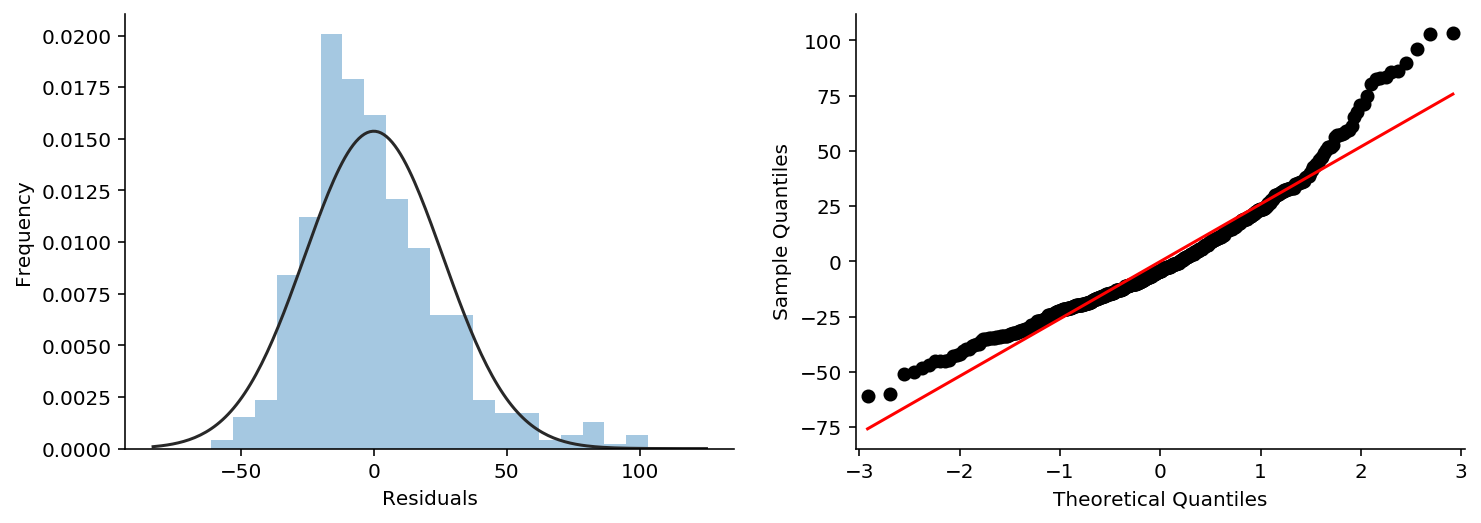

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
idx = X.argsort()
X_ = sm.add_constant(X.iloc[idx])
Y_ = Y.iloc[idx]
Yhat = results.predict(X_)
residuals = Y_ - Yhat

sns.distplot(residuals, 20, kde=False, fit=scipy.stats.norm, ax=ax)
ax.set_xlabel('Residuals')
ax.set_ylabel('Frequency')

ax = axes[1]

sm.graphics.qqplot(residuals, color='k', line='s', ax=ax)
sns.despine()

# GLM

With `statsmodels` it is easy to use [generalized linear models](http://www.statsmodels.org/stable/glm.html) (GLM) to change the probability distribution.

For example, since `y` is an integer, it might be better to use the **Poisson distribution**.

In [32]:
X_ = sm.add_constant(X) # for intercept
results_poi = sm.GLM(Y, X_, family=sm.families.Poisson()).fit()
results_poi.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                    Generalized Linear Model Regression Results                     
====================================================================================
Dep. Variable:     player1 total points won   No. Observations:                  565
Model:                                  GLM   Df Residuals:                      563
Model Family:                       Poisson   Df Model:                            1
Link Function:                          log   Scale:                          1.0000
Method:                                IRLS   Log-Likelihood:                -3869.1
Date:                      Sun, 14 Jul 2019   Deviance:                       4223.3
Time:                              18:13:28   Pearson chi2:                 4.43e+03
No. Iterations:                           4                                         
Covariance Type:                  nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            4.2160      0.009    489.118      0.000       4.199       4.233
player1 aces     0.0386      0.001     31.381      0.000       0.036       0.041
================================================================================
"""

The coefficients are on a different scale because when using the Poisson distribution we assumed that $\log(y) = ax + b$ rather than $y=ax+b$; here the $\log$ function is the *link function*.

The model parameters can be interpreted as follows:
- $e^b$ is the estimate for points won if 0 points were aced, $e^b = \widehat{y}(x=0)$, and
- $e^a$ is the estimate for the multiplicative increase in points won for every additional ace, $e^a = \frac{\widehat{y}(x+1)}{\widehat{y}(x)}$.



Normal:
  additive effect of aces=3.462
  without aces=65.552
Poisson:
  multiplicative effect of aces=1.039
  without aces=67.759


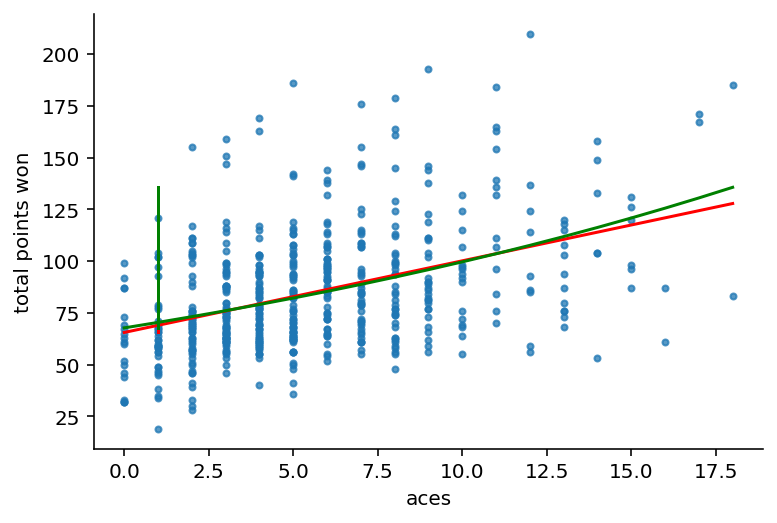

In [31]:
fig, ax =plt.subplots()

ax.scatter(X, Y, marker='.', alpha=0.75)
X_ = sm.add_constant(X.sort_values())

b, a = results.params
Yhat = results.predict(X_)
ax.plot(X_, Yhat, '-r')
print("Normal:\n  additive effect of aces={:.3f}\n  without aces={:.3f}".format(a, b))

b_poi, a_poi = results_poi.params
Yhat_poi = results_poi.predict(X_)
ax.plot(X_, Yhat_poi, '-g')
ax.set_xlabel('aces')
ax.set_ylabel('total points won')
print("Poisson:\n  multiplicative effect of aces={:.3f}\n  without aces={:.3f}".format(np.exp(a_poi), np.exp(b_poi)))

sns.despine()

There are many more twists to add, such as regularization, outlier detection, and linking functions - we'll do the latter in the next session when we deal with the classical classification method, *logistic regression*.

# References

- Pawitan Y, 2001. *In all likelihood: statistical modelling and inference using likelihood*. **Ch. 6.1**.
- Allen B. Downey, 2014. [Think Stats: Probability and Statistics for Programmers.](http://www.greenteapress.com/thinkstats2/index.html) (Available for free online).
- Cyrille Rossant, 2014. [IPython Interactive Computing and Visualization Cookbook](https://ipython-books.github.io/cookbook/) (the Tennis data is borrowed from there).
- Illustrate distributions using the [Seeing Theory](http://students.brown.edu/seeing-theory/probability-distributions/index.html#section2) webpage.
- Explore how regression is affected by outliers using the [Seeing Theory](http://students.brown.edu/seeing-theory/regression-analysis/index.html#section1) webpage.

# Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Data Science with Python_](https://python.yoavram.com/Deep4Devs) workshops.

The notebook was written using [Python](http://python.org/) 3.6.3, [IPython](http://ipython.org/) 6.2.1, [Jupyter](http://jupyter.org) 5.1.0.

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)